# UCLA Urban Data Science Final Project
## Exploring Electric Scooters Around UCLA Campus
### By Joanny Leyva and Matthews Cribioli

Welcome to our final project notebook for the course Urban Data Science taught at UCLA by Professor Adam-Millard Ball. If you're interested in learning more about the course, please follow this [link](https://urbandatascience.its.ucla.edu/) to the course website. 

The goal of this project was to analyze scooter patterns on the UCLA campus. The code as follows takes in data recorded from the Transit App API, determines the amount of scooters surrounding each building, and uses building attributes from Open Street Maps to create machine learning models as well as analyze their performance. This is repeated for the entire dataset, as well as data subsets for the morning, noon, and evening. We then cluster the results to find if any particular building's characteristics and scooters in their proximity are similar enough to find patterns. This code is relatively flexible, can be recreated for any part of a city with high scooter ridership, and is especially useful in analyzing patterns on college campuses.

Our data consists of 10 minute calls to the API from 9am to 10pm. (If you're interested in gathering your own data from the Transit API, see the file 'Running ucla project loop.py'. You'll have to apply for your own [API key here](https://docs.google.com/forms/d/e/1FAIpQLScZbUsb1G1gRzIkEQo4FuuAbfzQbldTvu6-62j_pSRWPtKZiA/viewform))

The comments in the code should guide you through, however if any questions, please reach out by email to Matthews Cribioli at matthewscribioli@gmail.com

In [1]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
from shapely.ops import nearest_points
import osmnx as ox
import numpy as np
import glob
import warnings

warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', None)
pd.options.mode.chained_assignment = None

In [2]:
# Get a list of all the data file names
csv_names = glob.glob('Data/Scooters*'.format('csv'))

In [3]:
Scooterdata = pd.DataFrame()
 
# append the CSV files together into one large file
for file in csv_names:
    temp_df = pd.read_csv(file)
    temp_df = temp_df[['title', 'id','networkName','networkId','color','textColor','latitude','longitude','type','subtitle','stationProperties','time']]
    Scooterdata = pd.concat([Scooterdata , temp_df], ignore_index=True)

In [4]:
#Bring in Scooter data, create a geodataframe
scootergdf = gpd.GeoDataFrame(
    Scooterdata, geometry=gpd.points_from_xy(Scooterdata.longitude,Scooterdata.latitude, 
                                          crs='EPSG:4326'))
scootergdf = scootergdf.to_crs("ESRI:102003")
#keep only scooter data
filtered_scooterdf = scootergdf[scootergdf['type'] == 'electric-scooter']

# Set the geometry column explicitly for the filtered_scooterdf GeoDataFrame
filtered_scooterdf = filtered_scooterdf.set_geometry("geometry")

#turn the datetime data into just the hour
filtered_scooterdf['time'] = filtered_scooterdf['time'].apply(lambda x: x.split(' ')[1].split(':')[0])
filtered_scooterdf['time'] = filtered_scooterdf['time'].astype('float32')

#create different datasets depending on the time of day
filtered_scooterdf_morning = filtered_scooterdf.loc[(filtered_scooterdf['time'] < 11) & (filtered_scooterdf['time'] >= 9)]
filtered_scooterdf_noon = filtered_scooterdf.loc[(filtered_scooterdf['time'] < 14) & (filtered_scooterdf['time'] >= 11)]
filtered_scooterdf_night = filtered_scooterdf.loc[(filtered_scooterdf['time'] < 22) & (filtered_scooterdf['time'] >= 19)]

#make a list of those data sets to iterate over
List_of_scooter_datasets = [filtered_scooterdf , filtered_scooterdf_morning , filtered_scooterdf_noon , filtered_scooterdf_night]

In [5]:
#Select relavent building data columns
address = 'University of California, Los Angeles'
osm = ox.geometries_from_address(address,tags={'building':True},dist=1000)

columns_to_keep = ['geometry','building','height','name','addr:street','amenity','building:units','ele','sport','leisure']
osm = osm[columns_to_keep]

#Switch our CRS into a projected version for slightly more accuracy
osm = osm.to_crs("ESRI:102003")

In [6]:
#Perform our scooter analysis for each different dataset
i = 0
for dataset in List_of_scooter_datasets :
    i=i+1
    # Perform a spatial join between the datasets
    joined = gpd.sjoin(dataset, osm, how="inner", op="intersects")

    # Calculate distances using pandas
    joined["distance"] = joined.apply(
        lambda row: row["geometry"].distance(row["geometry"]), axis=1
    )

    # Determine proximity threshold 
    proximity_threshold = 6  # about 20 feet converted to meters

    # Count e-scooters near buildings
    scooters_near_buildings = joined[joined["distance"] <= proximity_threshold].groupby("name")["id"].count()

    # Analyze the counts
    print(scooters_near_buildings)

    # add total scooter counts back into building data
    building_scooter_count = osm.merge(scooters_near_buildings, on = 'name')
    building_scooter_count.columns = [*building_scooter_count.columns[:-1], 'Scooter_Count']

    # add dummy and other variables for atributes we might find important
    building_scooter_count['is_parking_lot'] = building_scooter_count['amenity'].apply(
                            lambda x: True if x=='parking' else False)
    building_scooter_count['is_sport'] = building_scooter_count['leisure'].apply(
                            lambda x: True if x=='sports_centre' or x=='sports_hall' or x=='stadium' or x=='fitness_centre' else False)
    building_scooter_count['is_medical'] = building_scooter_count['amenity'].apply(
                            lambda x: True if x=='clinic' or x=='hospital' else False)
    building_scooter_count['is_library'] = building_scooter_count['amenity'].apply(
                            lambda x: True if x=='library' else False)
    building_scooter_count['is_dorm'] = building_scooter_count['building'].apply(
                            lambda x: True if x=='dormitory' else False)
    building_scooter_count["lat"] = building_scooter_count.centroid.x
    building_scooter_count["long"] = building_scooter_count.centroid.y
    building_scooter_count["area"] = building_scooter_count['geometry'].area

    building_scooter_count[['height','building:units','ele']] = building_scooter_count[['height','building:units','ele']].fillna(-999)

    if i == 1:
        building_scooter_count_total = building_scooter_count
    elif i ==2:
        building_scooter_count_morning = building_scooter_count
    elif i ==3:
        building_scooter_count_noon = building_scooter_count
    elif i ==4:
        building_scooter_count_night = building_scooter_count
    else:
        print('Something messed up, check the code')
        
building_scooter_datasets = [building_scooter_count_total, building_scooter_count_morning, building_scooter_count_noon, building_scooter_count_night]

/Users/joannyleyva/Desktop/anaconda3/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3400: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


name
Acacia Residential Building                10
Ackerman Union                            697
Acosta Center                             102
Ahmanson-Lovelace Brain Mapping Center     33
Alpha Gamma Delta                          20
                                         ... 
Wasserman Building                        191
Wasserman Football Center                 463
West Alumni Center                          8
Wooden West                               118
Zeta Beta Theta                            44
Name: id, Length: 167, dtype: int64


/Users/joannyleyva/Desktop/anaconda3/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3400: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


name
Acacia Residential Building                     2
Ackerman Union                                 76
Acosta Center                                   4
Ahmanson-Lovelace Brain Mapping Center          2
Alpha Gamma Delta                               8
                                             ... 
University Cooperative Housing Association     19
Wasserman Building                             25
Wasserman Football Center                     142
Wooden West                                    11
Zeta Beta Theta                                12
Name: id, Length: 140, dtype: int64


/Users/joannyleyva/Desktop/anaconda3/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3400: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


name
Acacia Residential Building                 1
Ackerman Union                            102
Acosta Center                              11
Ahmanson-Lovelace Brain Mapping Center      6
Alpha Gamma Delta                           8
                                         ... 
Wasserman Building                         63
Wasserman Football Center                 178
West Alumni Center                          1
Wooden West                                 6
Zeta Beta Theta                            11
Name: id, Length: 150, dtype: int64


/Users/joannyleyva/Desktop/anaconda3/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3400: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


name
Acacia Residential Building                 3
Ackerman Union                            275
Acosta Center                              38
Ahmanson-Lovelace Brain Mapping Center     16
Alpha Gamma Delta                           2
                                         ... 
Wasserman Building                         20
Wasserman Football Center                  22
West Alumni Center                          3
Wooden West                                30
Zeta Beta Theta                            12
Name: id, Length: 150, dtype: int64


In [7]:
#Train our Random Forest model to predict number of scooters
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import contextily  as ctx

xvars = (['is_parking_lot','is_sport','is_medical','is_library','is_dorm','lat','long','height','building:units','ele','area'])
yvar = 'Scooter_Count'


<frozen importlib._bootstrap>:914: ImportWarning: _SixMetaPathImporter.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _SixMetaPathImporter.find_spec() not found; falling back to find_module()


Results of All Data. Predicted Mean Scooters: 499.6653. Actual Mean Scooters: 455.3548
Results of Morning Data. Predicted Mean Scooters: 76.0862. Actual Mean Scooters: 67.8491
Results of Noon Data. Predicted Mean Scooters: 92.0776. Actual Mean Scooters: 125.9821
Results of Night Data. Predicted Mean Scooters: 82.8056. Actual Mean Scooters: 100.6964


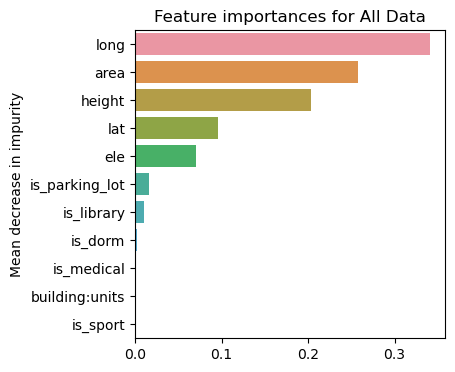

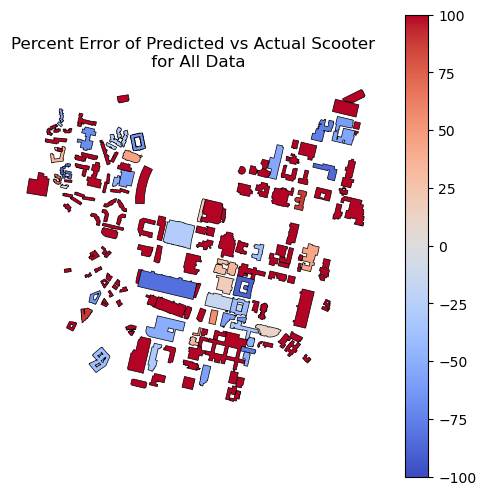

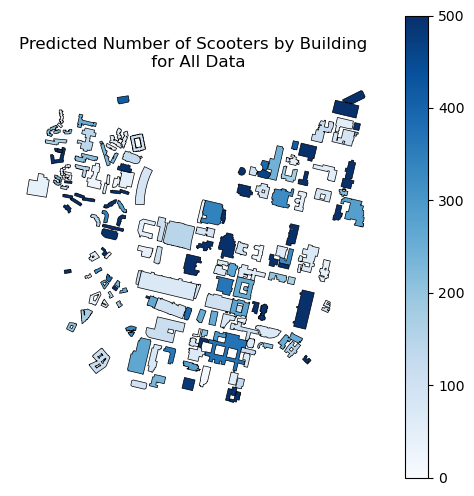

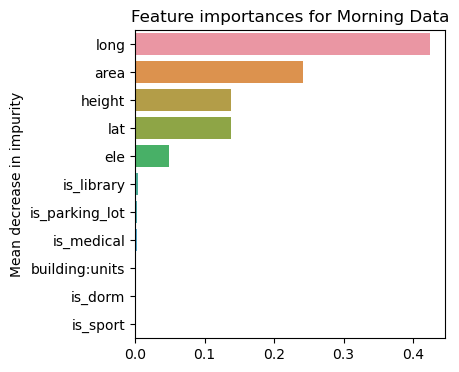

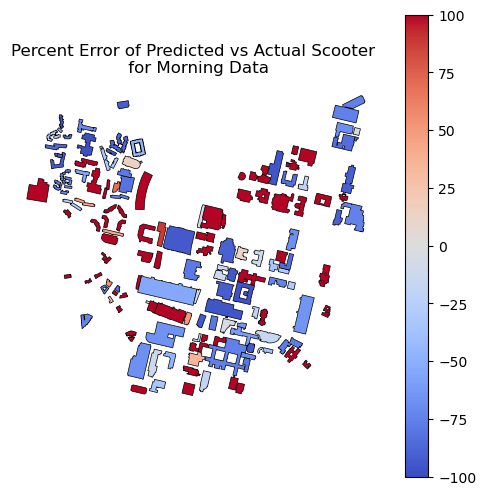

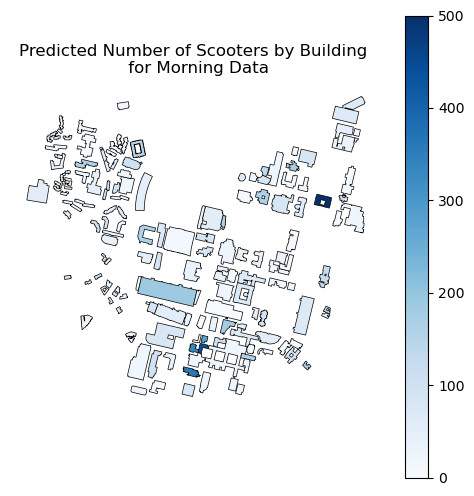

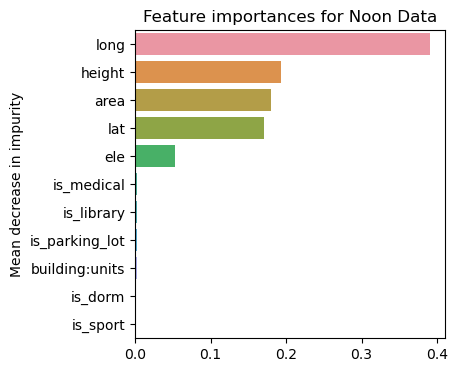

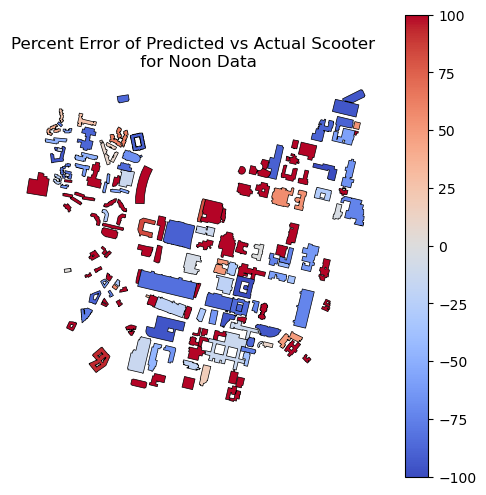

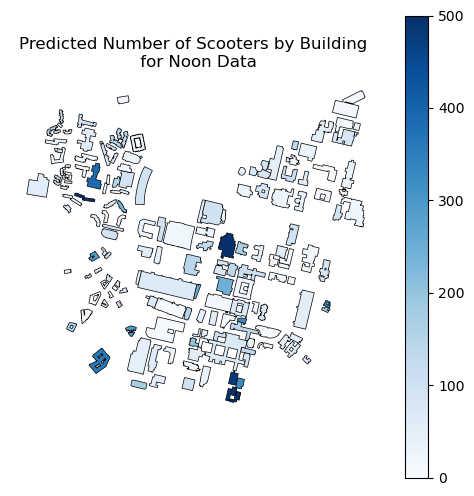

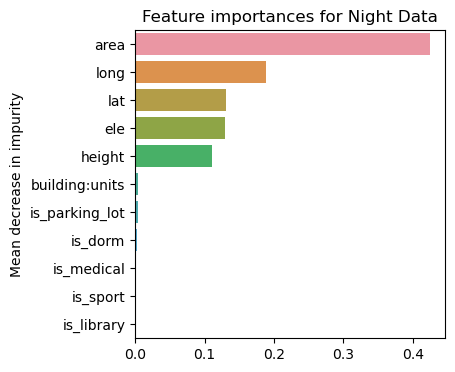

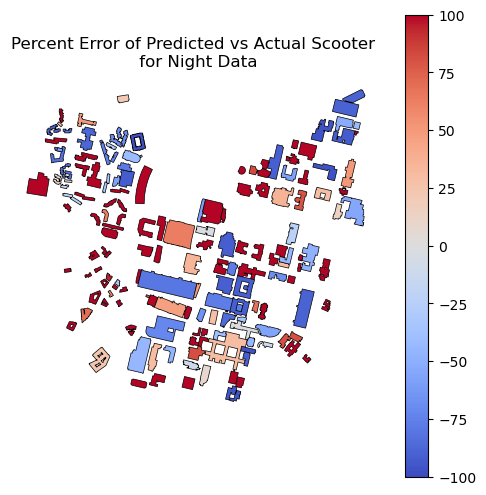

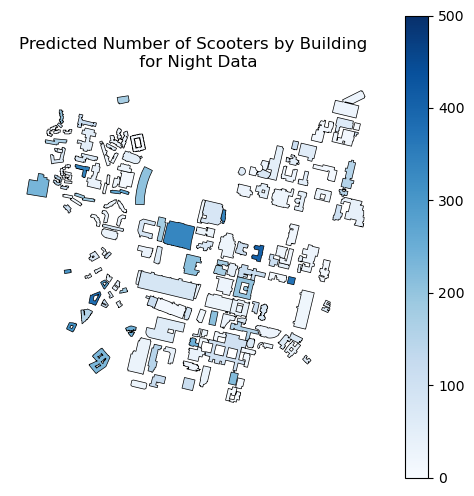

In [8]:
j=0
for building_scooter_dataset in building_scooter_datasets :
    j=j+1
    if j == 1:
        data_name = 'All Data'
    elif j ==2:
        data_name = 'Morning Data'
    elif j ==3:
        data_name = 'Noon Data'
    elif j ==4:
        data_name = 'Night Data'
    else:
        print('Something messed up, check the code')
        

    df_to_fit = building_scooter_dataset[xvars+[yvar]]#.dropna()

    X_train, X_test, y_train, y_test = train_test_split(
        df_to_fit[xvars], df_to_fit[yvar], test_size = 0.35, random_state = 2)

    rf = RandomForestRegressor(n_estimators = 200, random_state = 1, n_jobs=1)
    rf.fit(X_train, y_train)
    
    #How good is our prediction?
    y_pred = rf.predict(X_test)

    print('Results of {}. Predicted Mean Scooters: {:.4f}. Actual Mean Scooters: {:.4f}'.format( data_name,
        y_pred.mean(), y_test.mean()))
    
    #What atributes are most important in predicting scooter counts?

    importances = rf.feature_importances_

    forest_importances = pd.Series(importances, index=X_train.columns)

    std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

    forest_importances.sort_values(inplace=True, ascending=False)

    fig, ax = plt.subplots(figsize=(4,4))
    sns.barplot(x=forest_importances.values, y=forest_importances.index, ax=ax)
    ax.set_title("Feature importances for {}".format(data_name))
    ax.set_ylabel("Mean decrease in impurity")
    
    #lets take all our predicted scooter counts and add them to our building data to plot and see where our model is most accurate
    all_predict = rf.predict(pd.concat([X_test,X_train]))
    predictions = pd.DataFrame(all_predict, 
                               columns = ['Predicted_Scooters'])
    building_p_scooter_count = building_scooter_count.join(predictions)

    #Find the percent error for predicted scooter amounts and plot
    building_p_scooter_count['Percent_Error'] = ((building_p_scooter_count['Predicted_Scooters']-building_p_scooter_count['Scooter_Count'])/building_p_scooter_count['Scooter_Count'])*100


    fig, ax = plt.subplots(figsize=(6, 6))
    building_p_scooter_count.plot(column='Percent_Error', ax=ax, cmap = 'coolwarm', legend = True, vmax = 100, vmin= -100, edgecolor='black', linewidth = .5)
    ax.set_axis_off()
    ax.set_title("Percent Error of Predicted vs Actual Scooter \n for {}".format(data_name))
    plt.draw()
    
    fig, ax = plt.subplots(figsize=(6, 6))
    building_p_scooter_count.plot(column='Predicted_Scooters', ax=ax, cmap = 'Blues', legend = True, vmin= 0, vmax = 500, edgecolor='black', linewidth = .5)
    ax.set_axis_off()
    ax.set_title("Predicted Number of Scooters by Building \n for {}".format(data_name))
    plt.draw()
    

In [9]:
#What can clustering reveal to us? Are there certain atributes of buildings that lead to similar scooter counts?
from sklearn.cluster import KMeans
from sklearn import preprocessing

#Start by scaling our non-geographic and non-dummy variables,
#keeping only the variables which had any importance in the machine learning models.


cols_to_scale = ['lat','long','height','ele','area','Scooter_Count']

scaler = preprocessing.StandardScaler().fit(building_scooter_count_total[cols_to_scale])

building_scooter_count_total_scaled = pd.DataFrame(scaler.transform(building_scooter_count_total[cols_to_scale]),columns=cols_to_scale)

building_scooter_count_total_to_cluster = building_scooter_count_total_scaled

<frozen importlib._bootstrap>:914: ImportWarning: _SixMetaPathImporter.find_spec() not found; falling back to find_module()


In [10]:
#For this dataset, it is a bit difficult to determine how many clusters would make sense to use
#We use the 'elblow method' to determine the optimal amount of clusters to use to tell use the most amount
#of info with the least amount of clusters. I'm not an expert on Elbow Curves, and they were not covered in the course, so I've borrowed some code to assist us.
#code from https://stackoverflow.com/questions/41540751/sklearn-kmeans-equivalent-of-elbow-method 
distorsion = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(building_scooter_count_total_to_cluster)
    distorsion.append(kmeans.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 10), distorsion)
plt.grid(True)
plt.title('Building Scooter Cluster Elbow curve')
print('From this graph, our elbow or point of dimishining returns happens at around 7 clusters')

/Users/joannyleyva/Desktop/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


AttributeError: 'NoneType' object has no attribute 'split'

In [ ]:
#This code creates our 6 clusters, and assigns each building into one.
kmeans = KMeans(n_clusters=6, random_state=0).fit(building_scooter_count_total_to_cluster)
building_scooter_count_total_to_cluster['cluster_id'] = kmeans.labels_

In [ ]:
#Let's use a radar plot to find the common attributes of each plot to see if there are common patterns
# code from https://matplotlib.org/stable/gallery/specialty_plots/radar_chart.html
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D


def radar_factory(num_vars, frame='circle'):
    """
    Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle', 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarAxes(PolarAxes):

        name = 'radar'
        # use 1 line segment to connect specified points
        RESOLUTION = 1

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta

def radar_plot(kmeans, df_scaled):
    N  = kmeans.cluster_centers_.shape[1]  # number of columns / variables
    k = kmeans.n_clusters
    theta = radar_factory(N, frame='polygon')
    data = kmeans.cluster_centers_.T
    spoke_labels = [col for col in df_scaled.columns if col!='cluster_id']
    fig, ax = plt.subplots(figsize=(9, 9),
                                subplot_kw=dict(projection='radar'))
    fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)

    ax.plot(theta, data) #, color=color)
    ax.set_varlabels(spoke_labels)

    # add legend relative to top-left plot
    labels = ['Cluster {}'.format(kk) for kk in range(k)]
    ax.legend(labels, loc=(0.9, .95),
                                labelspacing=0.1, fontsize='small')

In [ ]:
#Plotting out Radar plot
radar_plot(kmeans,building_scooter_count_total_to_cluster)

In [ ]:
### REPEAT FOR BUS LOCATIONS? ###

In [ ]:
print(building_scooter_count_total_to_cluster.groupby('cluster_id').size())
print(building_scooter_count_total_to_cluster.groupby('cluster_id').mean())

From our clustering, we have a couple interesting patterns which emerge. 

* Cluster 0 has very low buildings, both in height and in elevation with about standard scooter counts. 
* Cluster 1 are buildings in the south east of campus with slightly lower scooters counts.
* Cluster 2 are buildings on the south west of campus, with slightly lower scooter counts than cluster 2.
* Cluster 3 had our large surface area buildings, which have slightly higher scooter counts than the median building.
* Cluster 4 is made up of high scooter count buildings, they are found in the north-west part of campus and are lower in height and elevation than the median building.
* Cluster 5 are mostly buildings on the north side of campus, a bit bigger and higher up in elevation with about median scooter counts. 
